### Loading libraries and dataset

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, Input, layers
from tensorflow.keras.applications import ResNet50

#bia

In [ ]:
url='/content/drive/MyDrive/Colab Notebooks/the_value_of_art/artDataset.csv'

## Uncoment this if you are loading data on a local file
## url =

df = pd.read_csv(url)

### Preprocessing

In [ ]:
df.dtypes

,0
Unnamed: 0,int64
price,object
artist,object
title,object
yearCreation,object
signed,object
condition,object
period,object
movement,object


In [ ]:
df['price'] = df['price'].map(lambda x: int(x.replace(".","")[:-4]))

In [ ]:
df['price'].sort_values().tail(10)

,price
150,50000
293,50000
215,54000
73,70000
396,70000
418,71500
415,75000
352,128000
148,135000
353,160000


<Axes: xlabel='None', ylabel='price'>

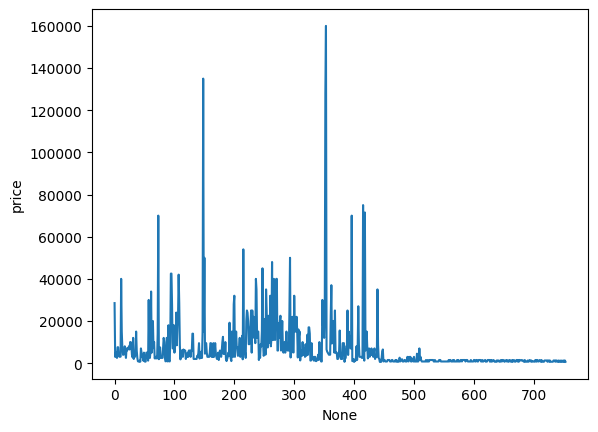

In [ ]:
sns.lineplot(x=df.index, y=df['price'])

### First Baseline

In [ ]:
first_baseline = df['price'].mean()
print(f"Our first baseline is {round(first_baseline, 2)}")

Our first baseline is 6760.77


In [ ]:
base_rmse = ((np.sum((df['price']-first_baseline)**2)/df['price'].count()))**0.5
print(f"Our first RMSE is {round(base_rmse, 2)}")

Our first RMSE is 12820.48


In [ ]:
base_mae = (np.sum(np.abs(df['price']-first_baseline))/df['price'].count())
print(f"Our first MAE is {round(base_mae, 2)}")

Our first MAE is 6775.93


This isn't at all a good baseline, The RMSE is greater than the precision itself by 1 order of maginitude. (And it is doubled)

### Loading images

#### Creating dataset

In [ ]:
price_df = df[['price']]

In [ ]:
price_df['file_name'] = 0

for i in price_df.index:
    price_df['file_name'][i] = f"image_{i+1}.png"

<ipython-input-32-db75a25b76dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['file_name'] = 0
<ipython-input-32-db75a25b76dd>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step an

In [ ]:
price_df

,price,file_name
0,28500,image_1.png
1,3000,image_2.png
2,5000,image_3.png
3,5000,image_4.png
4,2500,image_5.png
...,...,...
749,680,image_750.png
750,1275,image_751.png
751,680,image_752.png
752,1275,image_753.png


#### Actually updating images

In [ ]:
image_dir = "/content/drive/MyDrive/Colab Notebooks/the_value_of_art/artDataset"
X = []
y = []

In [ ]:
def load_and_preprocess(image_dir, image_name, target_size=(224, 224)):
    img = cv2.imread(f"{image_dir}/{image_name}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, target_size) / 255.0   # Resize + normalize
    return img

In [ ]:
for img_name, price in zip(price_df["file_name"], price_df["price"]):
    img = cv2.imread(f"{image_dir}/{img_name}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224)) / 255.0
    X.append(img)
    y.append(price)
X = np.array(X)
y = np.array(y)

In [ ]:
X.shape

(1465, 224, 224, 3)

In [ ]:
test_split = 0.2
index_split = int(len(X)*(1-test_split))

X_train = X[:index_split]
X_test = X[index_split:]
y_train = y[:index_split]
y_test = y[index_split:]

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1172, 224, 224, 3), (293, 224, 224, 3), (1172,), (293,))

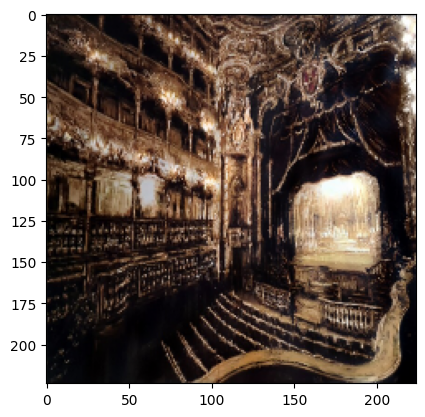

In [ ]:
plt.imshow(X[0])

### First CNN model (Pure CNN)

In [ ]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 346112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    44,302,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,395,841 (169.36 MB)

 Trainable params: 44,395,841 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 410ms/step - loss: 121870512.0000 - mae: 6541.9751 - val_loss: 311593152.0000 - val_mae: 8848.2754
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 188060480.0000 - mae: 7174.2202 - val_loss: 310890400.0000 - val_mae: 8856.2695
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 254530272.0000 - mae: 7531.9912 - val_loss: 311389504.0000 - val_mae: 8848.7129
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 160023712.0000 - mae: 6796.2144 - val_loss: 311564352.0000 - val_mae: 8845.5166
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 131298136.0000 - mae: 6522.4546 - val_loss: 311848992.0000 - val_mae: 8840.9492
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 149564000.0000 - mae: 6598.9897 - val_loss: 311601696.0000 - val_mae: 8843.1094
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 177039184.0000 - mae: 7009.6719 - val_loss: 311197216.0000 - val_mae: 8847.1455
Epoch 8/50
30/30 ━━

<Axes: >

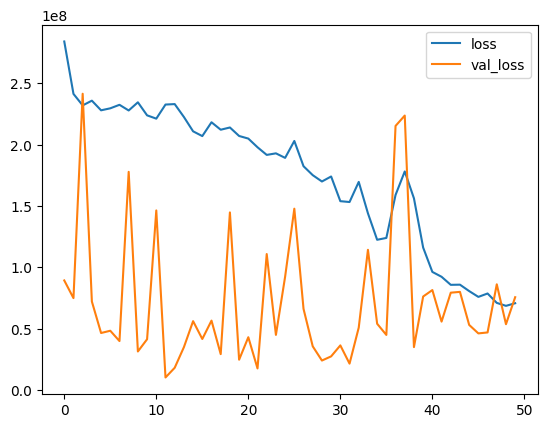

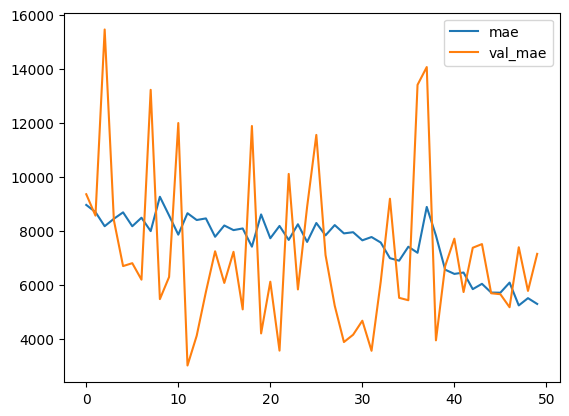

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['mae', 'val_mae']].plot()

In [ ]:
(model.evaluate(X_test, y_test)[0])**0.5

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 994ms/step - loss: 52911968.0000 - mae: 6122.0239


7307.424991062173

### Second Model (ResNet50)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1)  # Regression output
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 437ms/step - loss: 179051200.0000 - mae: 6872.5293 - val_loss: 315958176.0000 - val_mae: 8854.7939
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 203029072.0000 - mae: 7190.3911 - val_loss: 315256512.0000 - val_mae: 8860.7412
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 194568848.0000 - mae: 7394.7002 - val_loss: 315589216.0000 - val_mae: 8855.6357
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 233063760.0000 - mae: 7531.9229 - val_loss: 315395680.0000 - val_mae: 8856.4229
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 171524720.0000 - mae: 6845.2690 - val_loss: 314922720.0000 - val_mae: 8860.5547
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 152875424.0000 - mae: 6955.2446 - val_loss: 314455936.0000 - val_mae: 8864.6475
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 224568608.0000 - mae: 7510.3247 - val_loss: 314201120.0000 - val_mae: 8866.3350
Epoch 8/50
30/30 ━━

In [ ]:
model.evaluate(X_test,y_test)[1]

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 36533596.0000 - mae: 5963.9492


6081.57568359375

<Axes: >

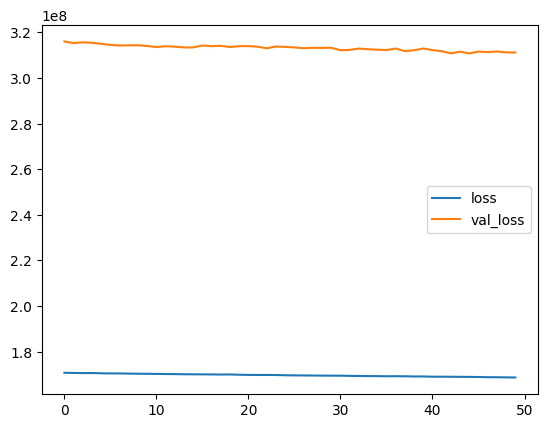

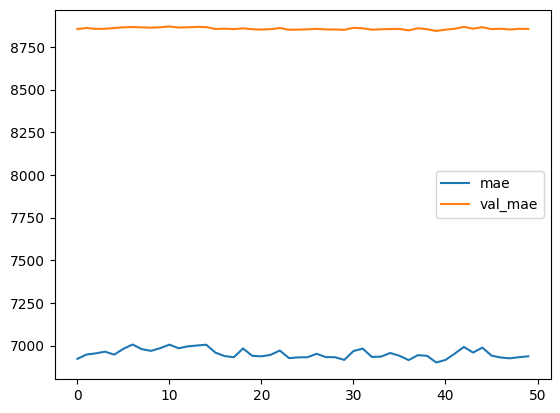

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['mae', 'val_mae']].plot()

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(model.predict(X_test), y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 512ms/step


6081.5751953125